In [31]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import seaborn as sns

# Carica il dataset
dataset = pd.read_csv(r"dataset.csv")

dataset_splitted = dataset[dataset['indic_bt'] == 'COST']

# Elimina le colonne specificate
dataset_splitted = dataset_splitted.drop(columns=['DATAFLOW', 'LAST UPDATE','s_adj', 'freq', 'cpa2_1', 'CONF_STATUS'])

# Filtra le righe dove OBS_FLAG è vuoto (rimuove righe con flag)
#dataset = dataset[dataset['OBS_FLAG'].isna() | (dataset['OBS_FLAG'] == '')]

dataset_splitted=dataset_splitted.drop(columns=['OBS_FLAG'])


dataset_splitted = dataset_splitted.fillna(dataset.mean(numeric_only=True))

print(dataset_splitted)

     indic_bt    unit geo  TIME_PERIOD  OBS_VALUE
0        COST     I15  AL         2002       86.2
1        COST     I15  AL         2003       88.6
2        COST     I15  AL         2004       91.3
3        COST     I15  AL         2005       92.5
4        COST     I15  AL         2006       93.5
...       ...     ...  ..          ...        ...
2242     COST  PCH_SM  TR         2023       64.0
2243     COST  PCH_SM  TR         2024       52.8
2244     COST  PCH_SM  UA         2022       27.8
2245     COST  PCH_SM  UA         2023       16.3
2246     COST  PCH_SM  UA         2024        8.7

[2247 rows x 5 columns]


In [32]:
# Crea la colonna 'serie' solo con 'geo' (dato che cpa2_1 è eliminata)
dataset_splitted['serie'] = dataset_splitted['geo']

# Crea la tabella pivot
pivot_df = dataset_splitted.pivot_table(index='TIME_PERIOD', columns='serie', values='OBS_VALUE')

print(pivot_df)

serie               AL         AT          BG         CY         CZ  \
TIME_PERIOD                                                           
1980               NaN        NaN         NaN        NaN        NaN   
1981               NaN        NaN         NaN        NaN        NaN   
1982               NaN        NaN         NaN        NaN        NaN   
1983               NaN        NaN         NaN        NaN        NaN   
1984               NaN        NaN         NaN        NaN        NaN   
1985               NaN        NaN         NaN        NaN        NaN   
1986               NaN        NaN         NaN        NaN        NaN   
1987               NaN        NaN         NaN        NaN        NaN   
1988               NaN        NaN         NaN        NaN        NaN   
1989               NaN        NaN         NaN        NaN        NaN   
1990               NaN  44.900000         NaN        NaN        NaN   
1991               NaN  32.733333         NaN        NaN        NaN   
1992  

In [33]:
## 1. Trasposizione
data = pivot_df.T

# 2. Rimuove righe completamente vuote
data = data.dropna(how='all')

# 3. Imputazione: riempi i NaN con la media di ogni riga
data_filled = data.apply(lambda row: row.fillna(row.mean()), axis=1)

# 4. Rimuovi righe che ancora hanno tutti NaN (es. Media era NaN)
data_filled = data_filled.dropna()

# 5. Controlla che siano rimaste almeno 2 righe
if data_filled.shape[0] < 2:
    print("Errore: troppo poche righe per il clustering.")
else:
    # 6. Standardizzazione
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_filled)

    # 7. Clustering con silhouette
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    best_k = 10
    best_score = -1

    for k in range(2, min(11, data_scaled.shape[0] + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, labels)
        print(f"Silhouette score per k={k}: {score:.3f}")

        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nMiglior numero di cluster: {best_k} con Silhouette Score = {best_score:.3f}")

    # Applica KMeans finale
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

Silhouette score per k=2: 0.621
Silhouette score per k=3: 0.387
Silhouette score per k=4: 0.435
Silhouette score per k=5: 0.290
Silhouette score per k=6: 0.304
Silhouette score per k=7: 0.291
Silhouette score per k=8: 0.244
Silhouette score per k=9: 0.297
Silhouette score per k=10: 0.271

Miglior numero di cluster: 2 con Silhouette Score = 0.621


In [34]:
# Crea un DataFrame con le serie originali
clustered_df = pd.DataFrame(data_filled)
clustered_df['cluster'] = labels
clustered_df.to_csv("clustered_countries.csv")

In [35]:
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}")
    print(clustered_df[clustered_df['cluster'] == i].index.tolist())


Cluster 0
['AL', 'AT', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EA20', 'EE', 'EL', 'ES', 'EU27_2020', 'FI', 'HU', 'IT', 'LT', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PT', 'RO', 'RS', 'SE', 'SI', 'TR']

Cluster 1
['UA']


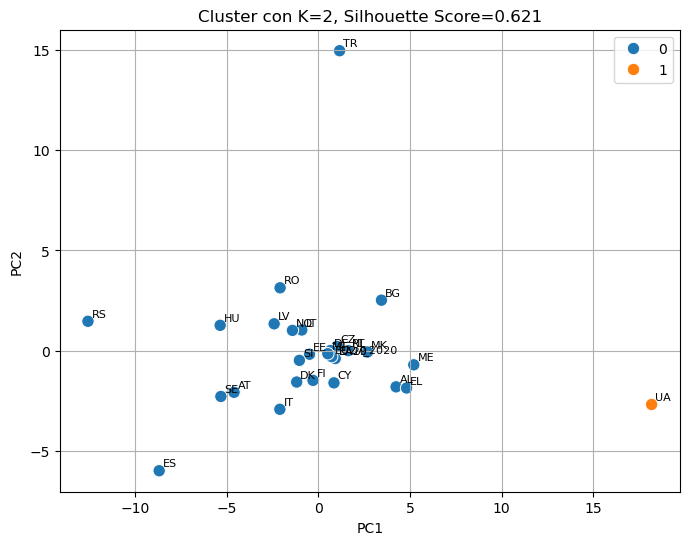

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Riduci a 2 dimensioni per lo scatter plot
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Scatter plot colorato per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=labels, palette='tab10', s=80)
for i, name in enumerate(data_filled.index):
    plt.text(data_2d[i, 0]+0.2, data_2d[i, 1]+0.2, name, fontsize=8)
plt.title("Visualizzazione dei cluster (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.title(f"Cluster con K={best_k}, Silhouette Score={best_score:.3f}")
plt.show()